In [189]:
import pandas as pd
import numpy as np
import pymssql  
import requests as re
import json
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt
import os

#  1.bus_line_clean

In [190]:
path =r"F:\201909\station"
files= os.listdir(path) 

sts_all=[]
nas_all=[]
sts_all=pd.DataFrame()
for file in files:
    name_i=file.replace('.txt','').replace(' ','')
    position=path+'\\'+file
    with open(position, "r",encoding='gbk') as f:
        data = f.read()  
        df_all=pd.DataFrame([c.split(',') for c in data.split(',\n')[:-1]],columns=['line','direction','sequence','station_name','lng','lat'])
        sts_all=pd.concat([df_all,sts_all])

In [ ]:
lines=list(set(list(sts_all['line'])))
new_sts=pd.DataFrame()
for i in lines:
    if sts_all[(sts_all['line']==i)&(sts_all['direction']=='0')].shape[0]>=sts_all[(sts_all['line']==i)&(sts_all['direction']=='0')].shape[0]:
        df1=sts_all[(sts_all['line']==i)&(sts_all['direction']=='0')]
        new_sts=pd.concat([df1,new_sts])
    else:
        df2=sts_all[(sts_all['line']==i)&(sts_all['direction']=='1')]
        new_sts=pd.concat([df1,new_sts])

In [193]:
new_sts=new_sts[['line','sequence','station_name','lng','lat']]

In [194]:
new_sts['sequence']=new_sts['sequence'].apply(lambda x:int(x))
new_sts['lng']=new_sts['lng'].apply(lambda x:float(x))
new_sts['lat']=new_sts['lat'].apply(lambda x:float(x))

###  1.2 station_shapefile

In [ ]:
#  构建点文件
stations=list(new_sts['station_name'])
lng_all=[]
lat_all=[]
for i in stations:
    lng_all.append(list(new_sts[new_sts['station_name']==i]['lng'])[0])
    lat_all.append(list(new_sts[new_sts['station_name']==i]['lat'])[0])
sta=pd.DataFrame()
sta['station']=stations
sta['lng']=lng_all
sta['lat']=lat_all

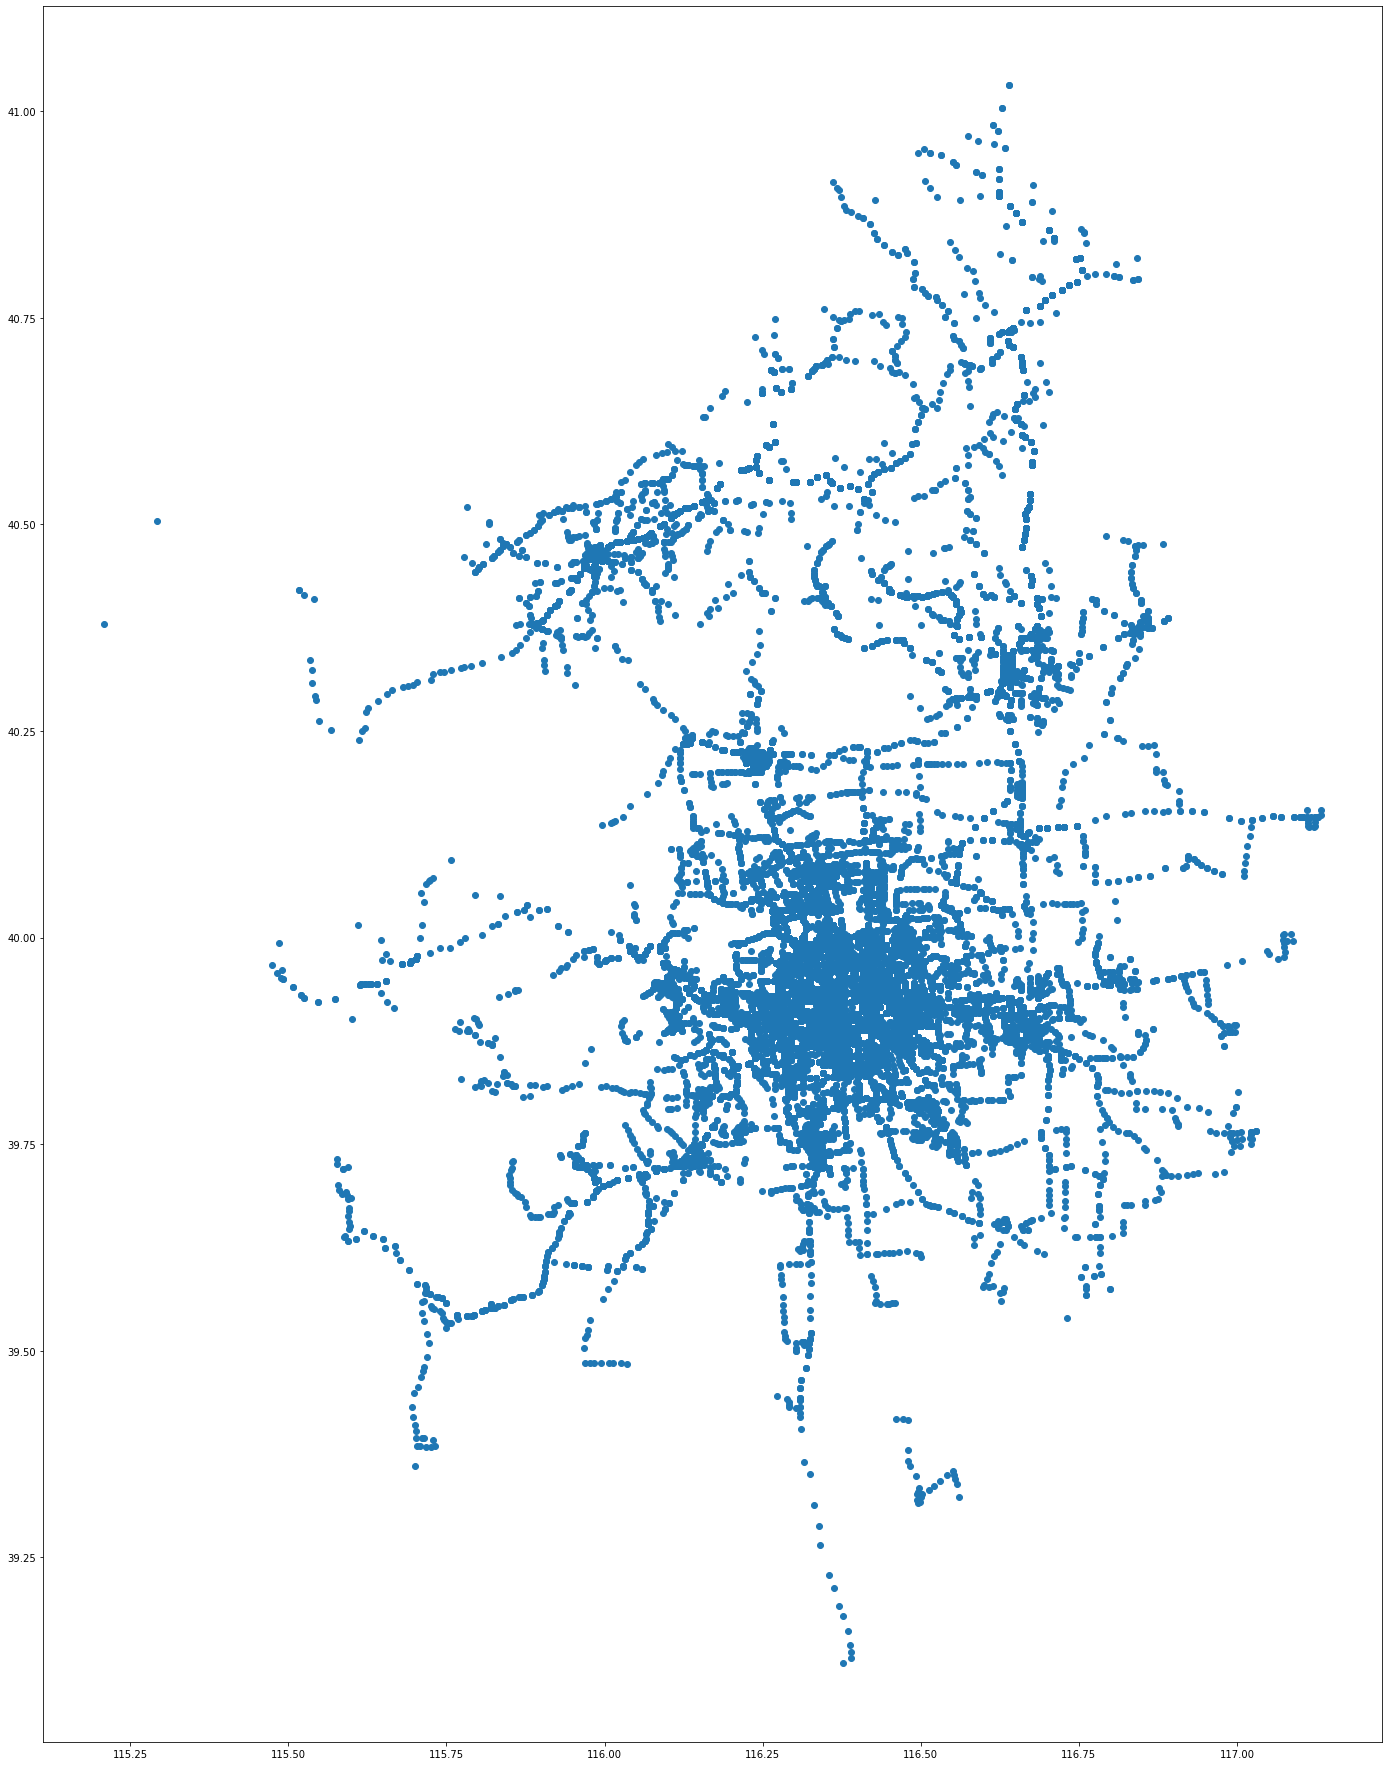

In [196]:
ss_all = gpd.GeoDataFrame(sta[['station','lng','lat']],
                          geometry=gpd.points_from_xy(sta['lng'],sta['lat'],crs='epsg:4326'))
ss_all.plot(figsize=(24,32))
plt.show()
ss_all.to_file(r'shapefile\bus_station.shp',driver='ESRI Shapefile',encoding='utf-8')

###  1.3 line_shapefile

In [199]:
lines=list(set(list(new_sts['line'])))
cq=[]
sts_all=[]
lis=[]
for i in lines:
    line_i=new_sts[new_sts['line']==i]
    if line_i.shape[0]>1:
        line_i=line_i.sort_values(by='sequence')
        cq.append(geometry.LineString([(line_i.iloc[i,3],line_i.iloc[i,4]) for i in range(line_i.shape[0])]))
        sts_all.append(list(line_i['station_name']))
        lis.append(i)
line_shp=gpd.GeoDataFrame(geometry=cq,crs='epsg:4326')
line_shp['line']=lis
line_shp['stations']=sts_all

In [200]:
l_sp=line_shp.copy()
l_sp['stations']=l_sp['stations'].apply(lambda x:str(x))

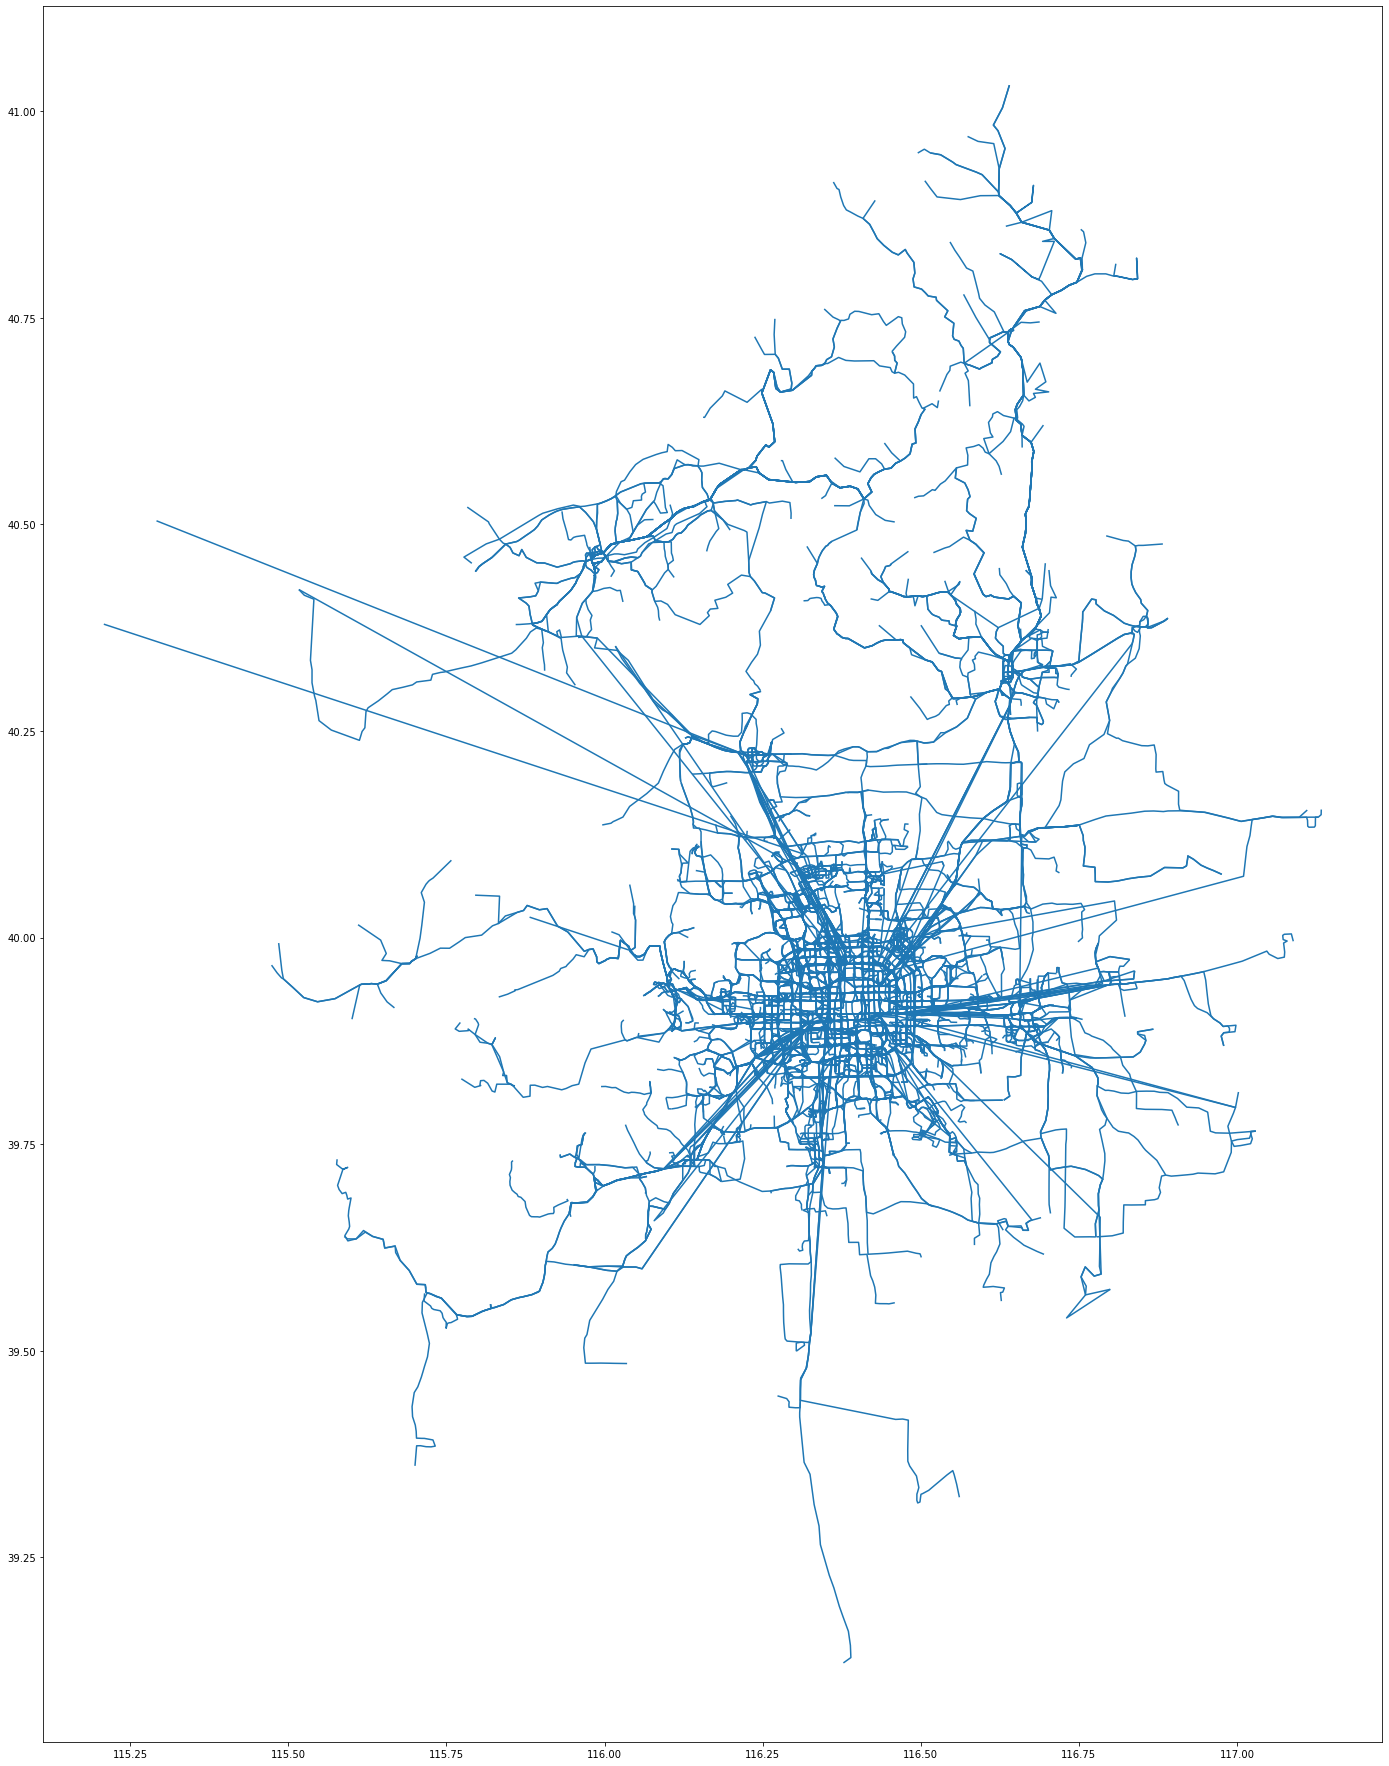

In [201]:
line_shp.plot(figsize=(24,32))
plt.show()
l_sp.to_file(r'shapefile\bus_line.shp',driver='ESRI Shapefile',encoding='utf-8')

###  1.4 

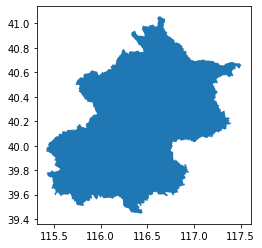

,省,geometry
17,北京市,"POLYGON ((116.62585 41.05887, 116.62638 41.058..."


In [202]:
sh01=gpd.read_file(r'面域数据\市.shp')
bj_sh=sh01[sh01['省']=='北京市'][['省','geometry']]
bj_sh.plot()
plt.show()
bj_sh.head()

In [272]:
bj_sh.to_file(r'shapefile\beij_my.shp',driver='ESRI Shapefile',encoding='utf-8')

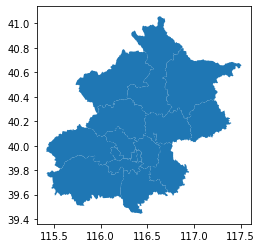

In [274]:
sh02=gpd.read_file(r'面域数据\县.shp') # 读取全国面域文件
bj_sh02=sh02[sh02['省']=='北京市'][['市','县','县类型','geometry']]
bj_sh02.plot()
plt.show()

In [275]:
bj_sh02.to_file(r'shapefile\beij_fq.shp',driver='ESRI Shapefile',encoding='utf-8')

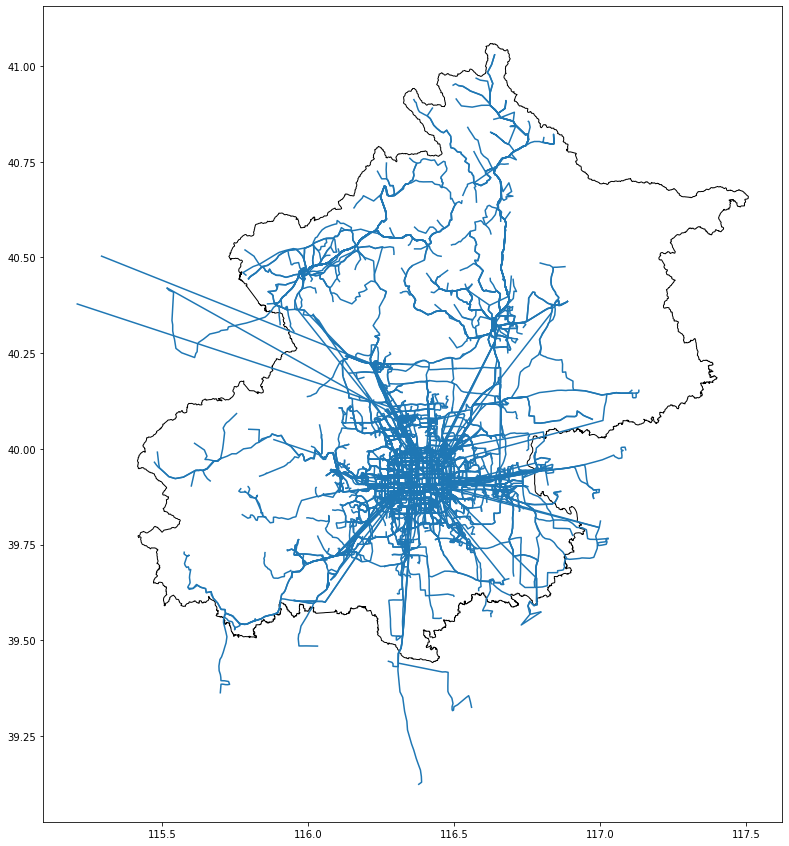

In [203]:
fig,ax = plt.subplots(figsize=(15,15))

line_shp.plot(ax=ax)

bj_sh.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

In [204]:
line_shp.head(1)

,geometry,line,stations
0,"LINESTRING (116.42366 39.85051, 116.41722 39.8...",43,"[五间楼, 贾家花园, 赵公口桥南, 刘家窑桥西, 刘家窑桥北, 蒲黄榆, 东侧路, 法华寺..."


In [205]:
line_shp.shape

(1078, 3)

In [206]:
bj_sh=bj_sh.to_crs('epsg:4326')

In [207]:
line_shp_refresh= gpd.sjoin(line_shp,bj_sh,predicate='within')
line_shp_refresh.shape

(1040, 5)

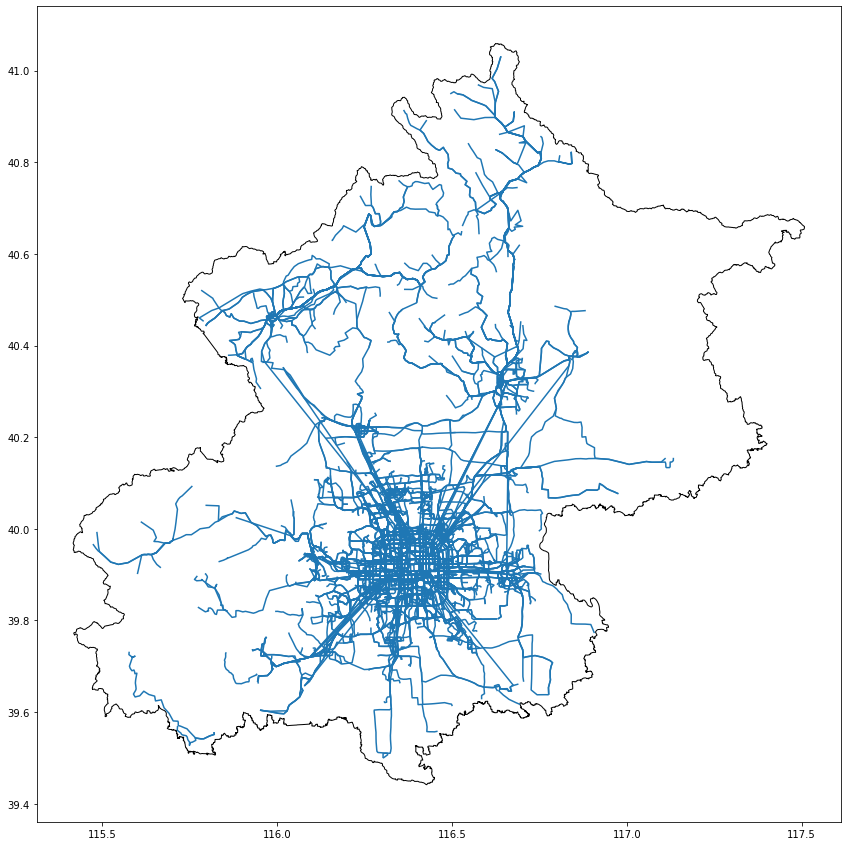

In [209]:
fig,ax = plt.subplots(figsize=(15,15))

line_shp_refresh.plot(ax=ax)

bj_sh.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

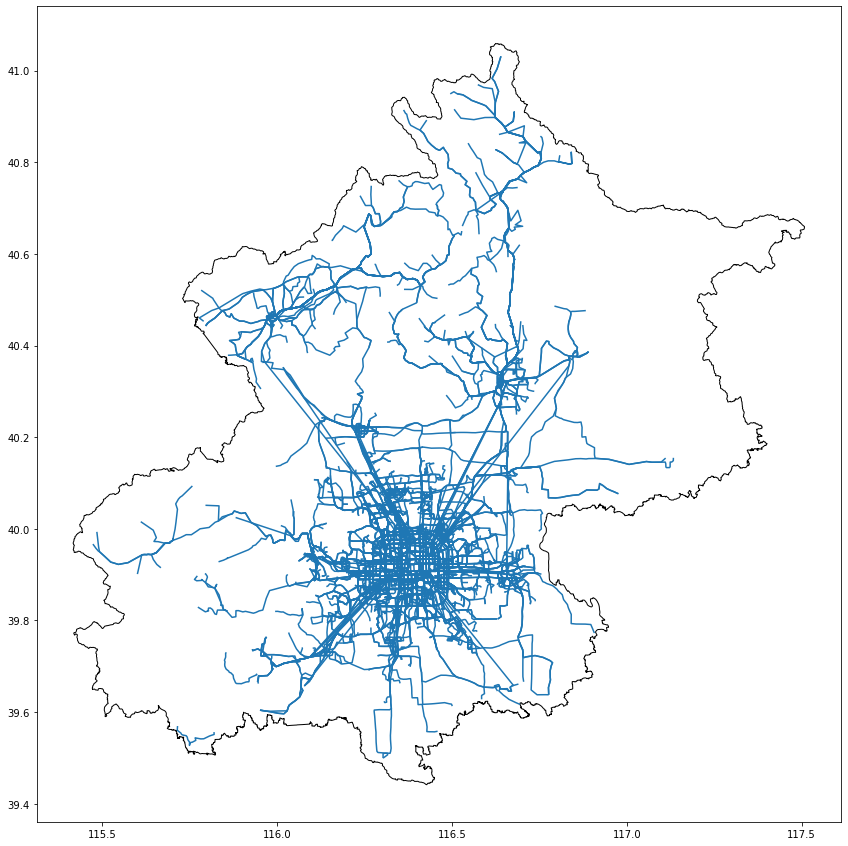

In [210]:
line_shp_refresh=line_shp_refresh[line_shp_refresh['line']!='F17']
fig,ax = plt.subplots(figsize=(15,15))

line_shp_refresh.plot(ax=ax)

bj_sh.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

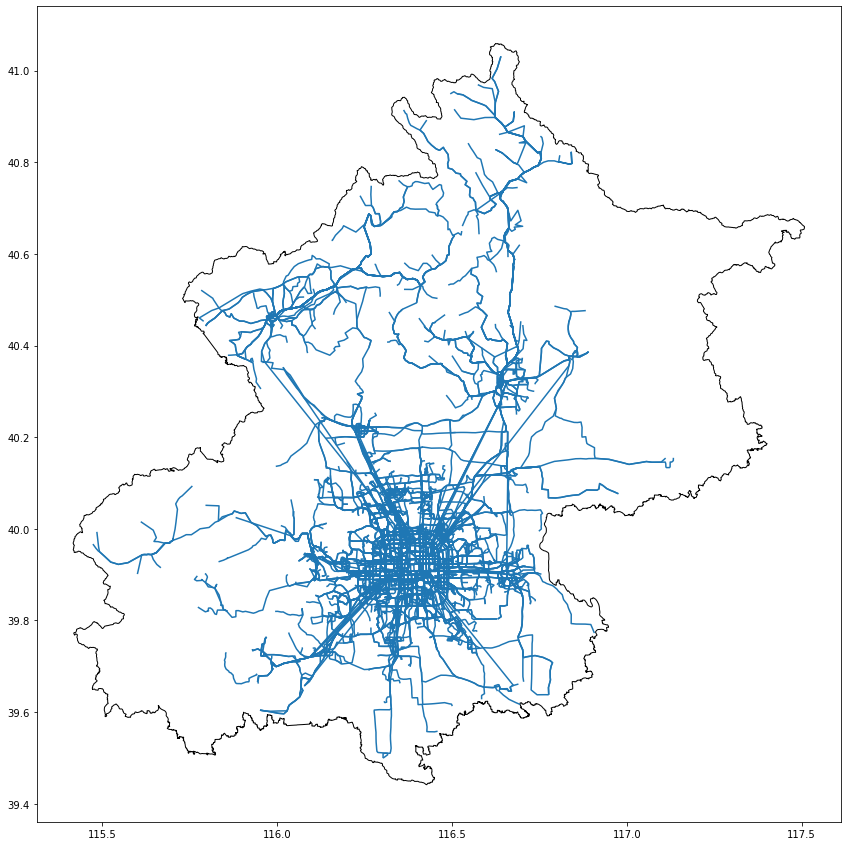

In [211]:
line_shp_refresh=line_shp_refresh[line_shp_refresh['line']!='F54']
fig,ax = plt.subplots(figsize=(15,15))

line_shp_refresh.plot(ax=ax)

bj_sh.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

#### 1.4.2 station_file

In [214]:
ss_all_refresh= gpd.sjoin(ss_all,bj_sh,predicate='within')
ss_all_refresh.shape

(27397, 6)

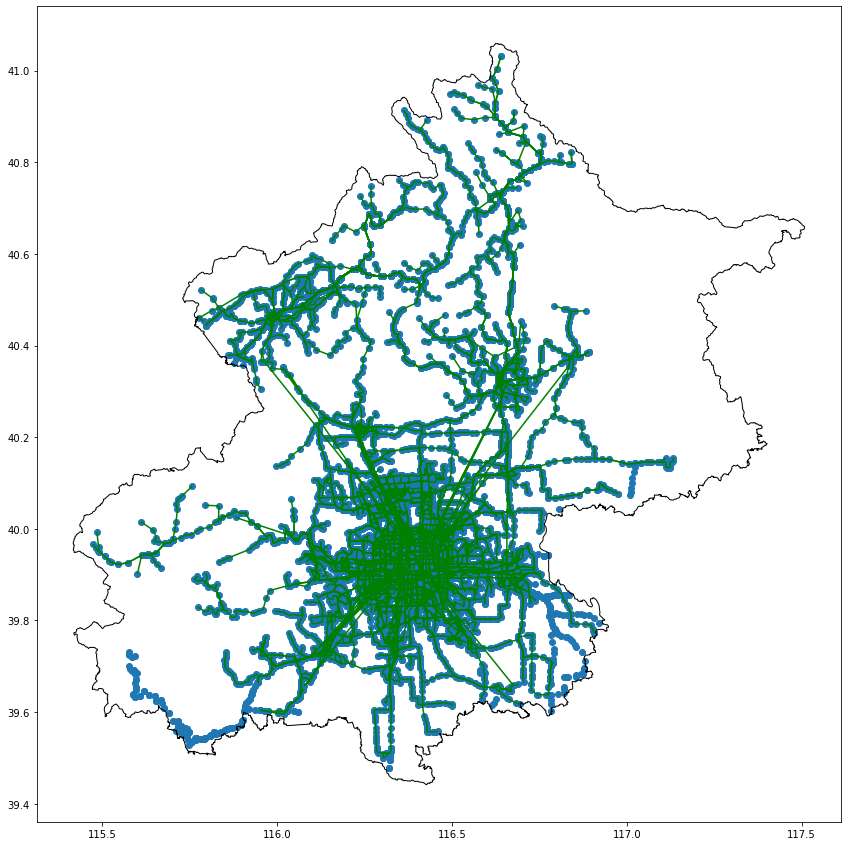

In [215]:
fig,ax = plt.subplots(figsize=(15,15))

ss_all_refresh.plot(ax=ax)
line_shp_refresh.plot(ax=ax,color='g')
bj_sh.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

In [261]:
sts=[]
[sts.extend(line_shp_refresh.iloc[c,1]) for c in range(line_shp_refresh.shape[0])]
len(sts)

26804

In [213]:
sts=list(set(sts))
sts=pd.DataFrame(sts,columns=['station'])
lngs=[]
lats=[]
gps=[]
for i in range(sts.shape[0]):
    lngs.append(list(ss_all_refresh[ss_all_refresh['station']==sts.iloc[i,0]]['lng'])[0])
    lats.append(list(ss_all_refresh[ss_all_refresh['station']==sts.iloc[i,0]]['lat'])[0])
    gps.append(list(ss_all_refresh[ss_all_refresh['station']==sts.iloc[i,0]]['geometry'])[0])
sts['lng']=lngs
sts['lat']=lats
sts['geometry']=gps

(27849, 4)

<AxesSubplot:>

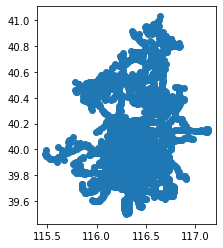

In [265]:
ss_shp = gpd.GeoDataFrame(sts[['station','lng','lat']],
                          geometry=gpd.points_from_xy(sts['lng'],sts['lat'],crs='epsg:4326'))
ss_shp.plot()

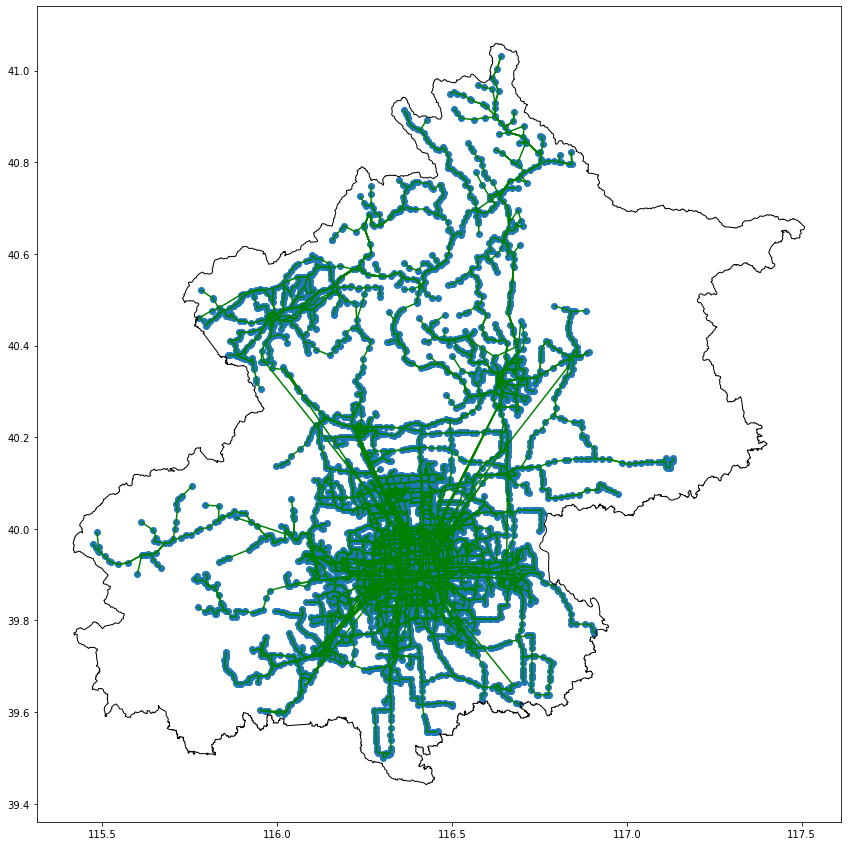

In [266]:
fig,ax = plt.subplots(figsize=(15,15))

ss_shp.plot(ax=ax)
line_shp_refresh.plot(ax=ax,color='g')
bj_sh.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

####  生成 final shapefile

In [267]:
ss_shp.to_file(r'shapefile\bus_station.shp',driver='ESRI Shapefile',encoding='utf-8')

In [271]:
li=line_shp_refresh.copy()
li['stations']=li['stations'].apply(lambda x:str(x))
li.to_file(r'shapefile\bus_line.shp',driver='ESRI Shapefile',encoding='utf-8')

In [277]:
ss_shp.to_csv('bus_station.csv',encoding='gbk')

In [278]:
line_shp_refresh.to_csv('bus_line.csv',encoding='gbk')